In [94]:
import numpy as np
import matplotlib
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler, Sampler


In [48]:
df = pd.read_csv(r'./train.csv')

In [40]:
#temporary crop dataset for fast testing
df = df[0:1000]

In [41]:
df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [43]:
df.shape

(1000, 15)

In [79]:
df.dtypes

id                 int64
epoch     datetime64[ns]
sat_id             int64
x                float64
y                float64
z                float64
Vx               float64
Vy               float64
Vz               float64
x_sim            float64
y_sim            float64
z_sim            float64
Vx_sim           float64
Vy_sim           float64
Vz_sim           float64
dtype: object

In [78]:
df.epoch = pd.to_datetime(df.epoch)

In [46]:
df.loc[902].epoch - df.loc[901].epoch

Timedelta('0 days 00:46:43.001000')

In [82]:
count_by_sat = df.groupby('sat_id').id.count()
print(f'минимальное кол-во данных на спутник {count_by_sat.min()}')
print(f'максимальное кол-во данных на спутник {count_by_sat.max()}')
print(f'среднее кол-во данных на спутник {count_by_sat.mean():.0f}')
print(f'медианное кол-во данных на спутник {count_by_sat.median():.0f}')
count_by_sat.describe()

минимальное кол-во данных на спутник 94
максимальное кол-во данных на спутник 6320
среднее кол-во данных на спутник 1083
медианное кол-во данных на спутник 676


count     600.000000
mean     1083.186667
std      1093.148473
min        94.000000
25%       389.250000
50%       676.000000
75%      1364.000000
max      6320.000000
Name: id, dtype: float64

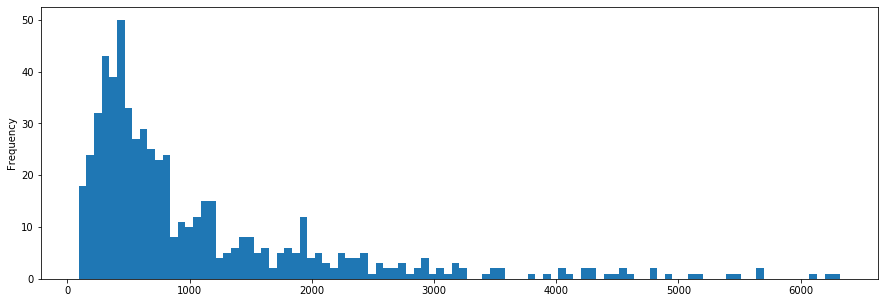

In [73]:
count_by_sat.plot.hist(bins=100, figsize=(15,5))

In [83]:
data_train = torch.from_numpy(df.drop(columns='epoch').values)

In [84]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [85]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return torch.mean(torch.abs((satellite_predicted_values - satellite_true_values) 
        / (torch.abs(satellite_predicted_values) + torch.abs(satellite_true_values)))) 

In [96]:
#code to test, that loss function generate gradients
model = nn.Linear(2, 2)
x = torch.randn(1, 2)
target = torch.randn(1, 2)
output = model(x)
loss = smape(output, target)
loss.backward()
print(model.weight.grad)

tensor([[-0.0604,  0.1801],
        [-0.0000,  0.0000]])


In [ ]:
nn_model = nn.Sequential(
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
loss = smape
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
        if scheduler is not None:
            scheduler.step()
                
    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    correct_samples = 0
    total_samples = 0
    
    for x, y in loader:
        prediction = torch.argmax(model(x), dim=1)
        correct_samples += torch.sum(prediction == y)
        total_samples += y.shape[0]
    return float(correct_samples) / float(total_samples)